# Genesis4 Basic Example

This will show the basic usage of LUME-Genesis.

In [1]:
import genesis
import matplotlib.pyplot as plt
import numpy as np

from genesis.version4 import Genesis4
from genesis.version4.input import Track, Write

%config InlineBackend.figure_format = 'retina'

## Setup

Instantiate the object on a value init file. This will configure a working directory that stages all input and output files.

In [2]:
G = Genesis4("data/basic4/cu_hxr.in", "data/basic4/hxr.lat", verbose=True)

Inspect the main input by filtering the namelists by their type:

In [3]:
G.input.main.by_namelist[Track]

[Track(type='track', zstop=10.0, output_step=1, field_dump_step=0, beam_dump_step=0, sort_step=0, s0=0.0, slen=0.0, field_dump_at_undexit=False, bunchharm=1)]

In [4]:
for track in G.input.main.by_namelist[Track]:
    track.zstop = 92

In [5]:
G.input.main.by_namelist[Track]

[Track(type='track', zstop=92, output_step=1, field_dump_step=0, beam_dump_step=0, sort_step=0, s0=0.0, slen=0.0, field_dump_at_undexit=False, bunchharm=1)]

You can view the data as a convenient table, too:

In [6]:
G.input.main.by_namelist[Track][0]

Attribute,Value,Type,Description
type,track,str,
zstop,92,float,If `zstop` is shorter than the lattice length the tracking stops at the specified position.
output_step,1,int,Defines the number of integration steps before the particle and field distribution is analyzed for output.
field_dump_step,0,int,Defines the number of integration steps before a field dump is written. Be careful because for time-dependent simulation it can generate many large output files.
beam_dump_step,0,int,Defines the number of integration steps before a particle dump is written. Be careful because for time-dependent simulation it can generate many large output files.
sort_step,0,int,Defines the number of steps of integration before the particle distribution is sorted. Works only for one-4-one simulations.
s0,0.0,float,Option to override the default time window start from the TIME module.
slen,0.0,float,Option to override the default time window length from the TIME module.
field_dump_at_undexit,False,bool,Field dumps at the exit of the undulator (one dump for each undulator in the expanded lattice).
bunchharm,1,int,Bunching harmonic output setting. Must be >= 1.


In [7]:
# Add writing a field file
G.input.main.namelists.append(Write(field="end"))

# Add writing a beam (particle) file
G.input.main.namelists.append(Write(beam="end"))

In [8]:
import IPython

genesis.global_display_options.include_description = False

print("Viewed as an HTML table:")

for write in G.input.main.by_namelist[Write]:
    IPython.display.display(write)

Viewed as an HTML table:


Attribute,Value,Type
type,write,str
field,end,str
beam,,str
stride,1,int


Attribute,Value,Type
type,write,str
field,,str
beam,end,str
stride,1,int


In [9]:
print("View it as a markdown table for easy pasting to GitHub:")
for write in G.input.main.by_namelist[Write]:
    print(write)
    print()

View it as a markdown table for easy pasting to GitHub:
| Attribute | Value | Type |
| :-------: | :---: | :--: |
|    type   | write | str  |
|   field   |  end  | str  |
|    beam   |       | str  |
|   stride  |   1   | int  |

| Attribute | Value | Type |
| :-------: | :---: | :--: |
|    type   | write | str  |
|   field   |       | str  |
|    beam   |  end  | str  |
|   stride  |   1   | int  |



## Run
Run with MPI. Here, setting `G.nproc = 0` will automatically select the maximum number of CPUs.

In [10]:
G.nproc = 0
G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmplba0p2rg
Setting use_mpi = True because nproc = 0
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmplba0p2rg
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 0 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l hxr.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:36:11 2024

MPI-Comm Size: 12 nodes

Parsing lattice file...
Setting up time window of 15.2233 microns with 552 sample points...
Generating input radiation field for HARM = 1 ...


Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 552 slices for a time window of 15.2233 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done


  Calculation: 10% done


  Calculation: 20% done


  Calculation: 30% done


  Calculation: 40% done


  Calculation: 50% done


  Calculation: 60% done


  Calculation: 70% done


  Calculation: 80% done


  Calculation: 90% done


Calculation terminated due to requested stop.
Writing output file...



Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing field distribution to file: end.fld.h5 ...


Writing particle distribution to file: end.par.h5 ...



Program is terminating...
Ending Time: Tue May 14 16:40:04 2024
Total Wall Clock Time: 116.657 seconds
-------------------------------------
Success - execution took 232.40s.


Genesis4Output(run=error=False error_reason='' run_script='/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 0 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l hxr.lat genesis4.in' run_time=232.40184612502344)

In [11]:
if G.output.run.error:
    print(G.output.run.error_reason)
else:
    print("No error")

No error


## Output

The main output is an HDF5. The Genesis4 object loads all array data into a flat dict

In [12]:
list(G.output)

['Beam/LSCfield',
 'Beam/alphax',
 'Beam/alphay',
 'Beam/betax',
 'Beam/betay',
 'Beam/bunching',
 'Beam/bunchingphase',
 'Beam/current',
 'Beam/efield',
 'Beam/emax',
 'Beam/emin',
 'Beam/emitx',
 'Beam/emity',
 'Beam/energy',
 'Beam/energyspread',
 'Beam/pxmax',
 'Beam/pxmin',
 'Beam/pxposition',
 'Beam/pymax',
 'Beam/pymin',
 'Beam/pyposition',
 'Beam/wakefield',
 'Beam/xmax',
 'Beam/xmin',
 'Beam/xposition',
 'Beam/xsize',
 'Beam/ymax',
 'Beam/ymin',
 'Beam/yposition',
 'Beam/ysize',
 'Field/dgrid',
 'Field/intensity-farfield',
 'Field/intensity-nearfield',
 'Field/ngrid',
 'Field/phase-farfield',
 'Field/phase-nearfield',
 'Field/power',
 'Field/xdivergence',
 'Field/xpointing',
 'Field/xposition',
 'Field/xsize',
 'Field/ydivergence',
 'Field/ypointing',
 'Field/yposition',
 'Field/ysize',
 'Global/frequency',
 'Global/gamma0',
 'Global/lambdaref',
 'Global/one4one',
 'Global/s',
 'Global/sample',
 'Global/scan',
 'Global/slen',
 'Global/time',
 'Lattice/aw',
 'Lattice/ax',
 'Lat

This is the output file that was loaded

In [13]:
print("Took", G.output.run.run_time, "sec")

Took 232.40184612502344 sec


In [14]:
print(list(G.output.keys())[:10], "...")

['Beam/LSCfield', 'Beam/alphax', 'Beam/alphay', 'Beam/betax', 'Beam/betay', 'Beam/bunching', 'Beam/bunchingphase', 'Beam/current', 'Beam/efield', 'Beam/emax'] ...


In [15]:
print(G.output.alias["alphax"])

Beam/alphax


There are many outputs. `.output_info()` gives a convenient table describing what was read in.

In [16]:
G.output.info()

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

Attribute,Value,Type
Beam/LSCfield,"array: (2544, 552)",eV/m
Beam/alphax,"array: (1, 552)",rad
Beam/alphay,"array: (1, 552)",rad
Beam/betax,"array: (1, 552)",m
Beam/betay,"array: (1, 552)",m
Beam/bunching,"array: (2544, 552)",
Beam/bunchingphase,"array: (2544, 552)",rad
Beam/current,"array: (2544, 552)",A
Beam/efield,"array: (2544, 552)",eV/m
Beam/emax,"array: (2544, 552)",m_ec^2


## Fields

Field files can be very large and are made readily available for lazy loading.
Loaded fields are present in `.field` attribute of the output:

In [17]:
list(G.output.field)

[]

For convenience, fields and particles may be automatically loaded after a run by using `run(load_fields=True, load_particles=True)` instead.
Otherwise, these can be manually loaded individually or all at once:

In [18]:
G.output.load_fields()

['end']

In [19]:
list(G.output.field)

['end']

This field data has two parts: basic parameters `param`, and the raw 3D complex array `dfl`:

In [20]:
G.output.field["end"].param

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 552,
 'slicespacing': 2.7578489739904225e-08}

In [21]:
G.output.field["end"].dfl.shape

(101, 101, 552)

`.field` is a convenience property that points to this

In [22]:
G.output.field["end"].param

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 552,
 'slicespacing': 2.7578489739904225e-08}

## Visualize Field

In [23]:
# Sum over y and compute the absolute square
dfl = G.output.field["end"].dfl
param = G.output.field["end"].param
dat2 = np.abs(np.sum(dfl, axis=1)) ** 2

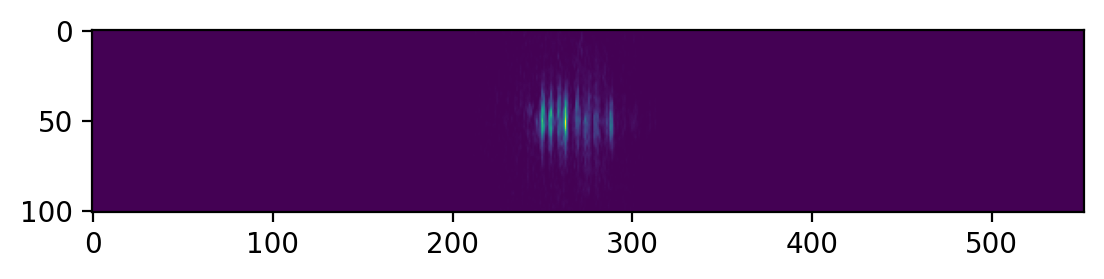

In [24]:
plt.imshow(dat2)

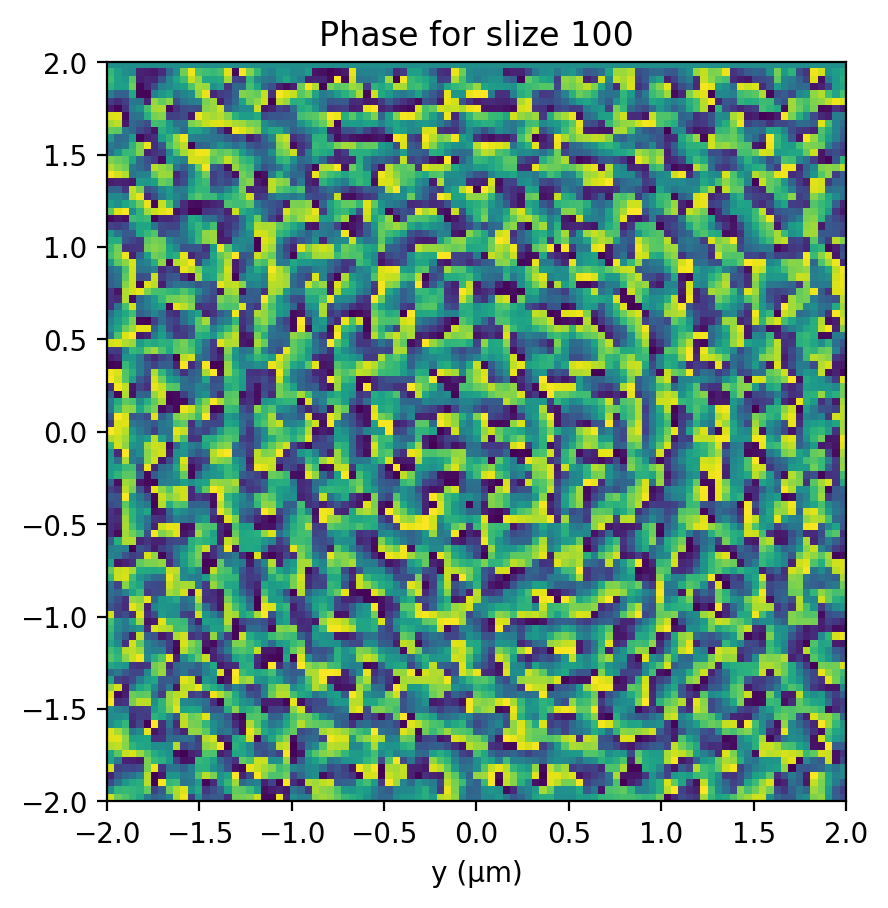

In [25]:
def plot_slice(i=0):
    dat = np.angle(dfl[:, :, i])

    dx = param["gridsize"] * 1e6
    plt.xlabel("x (µm)")
    plt.xlabel("y (µm)")
    plt.title(f"Phase for slize {i}")
    plt.imshow(dat.T, origin="lower", extent=[-dx, dx, -dx, dx])


plot_slice(i=100)

# Particles

Particle files can be read in as [openPMD-beamphysics](https://christophermayes.github.io/openPMD-beamphysics/) `ParticleGroup` objects.
These are lazily loaded by default (`run(load_particles=False)`). They may also be loaded all at once, with `load_particles()`. `output.particle_files` will only show not-yet-loaded particle files.

In [26]:
G.output.particle_files

{'end': _ParticleGroupH5File(key='end', filename=PosixPath('/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmplba0p2rg/end.par.h5'), type='particle_group')}

In [27]:
G.output.load_particles()

['end']

In [28]:
G.output.particles

{'end': <ParticleGroup with 565248 particles at 0x146744dd0>}

In [29]:
P = G.output.particles["end"]

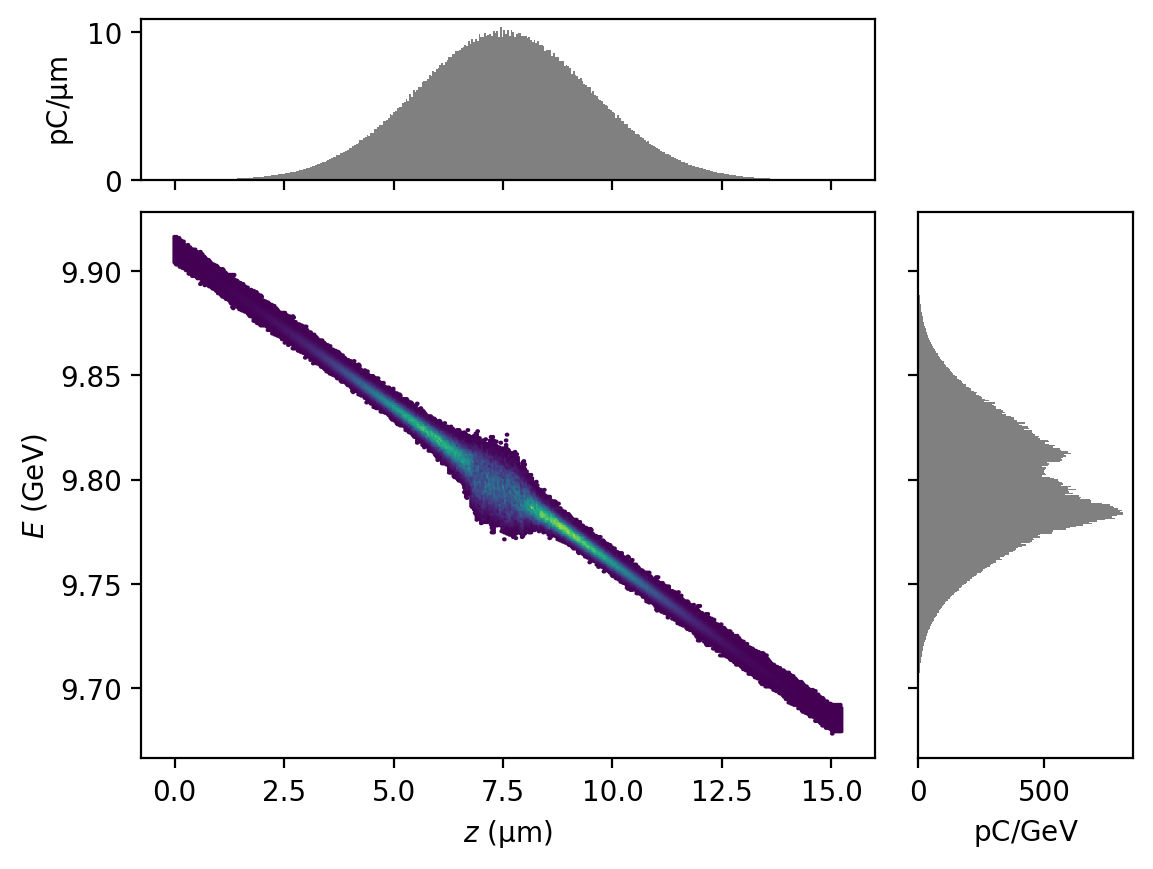

In [30]:
P.plot("z", "energy")

Change to z coordinates to see the current. Note that the head of the bunch is now on the left.

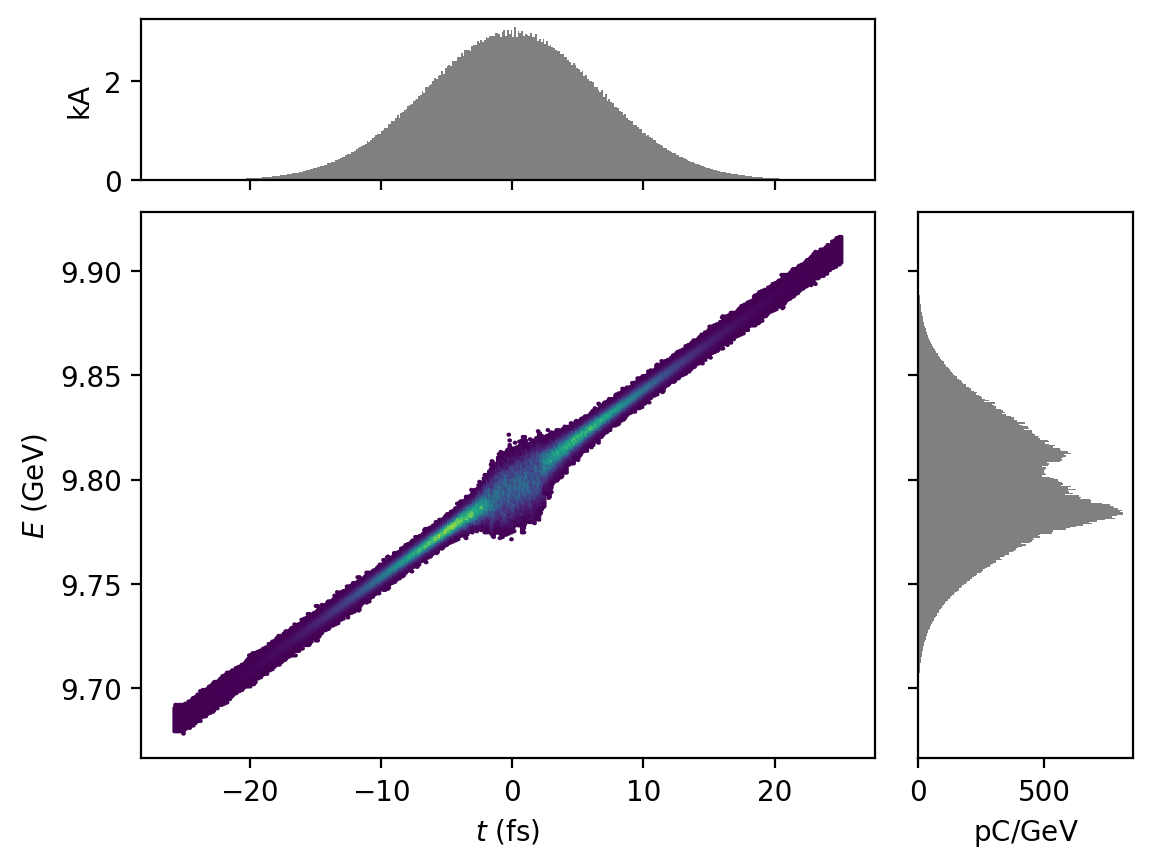

In [31]:
P.drift_to_z()
P.plot("t", "energy")

Check some statistics

In [32]:
P["norm_emit_x"], P["norm_emit_y"], P["mean_gamma"]

(4.000109622270027e-07, 4.000351554812418e-07, 19172.14812812367)

## Bunching

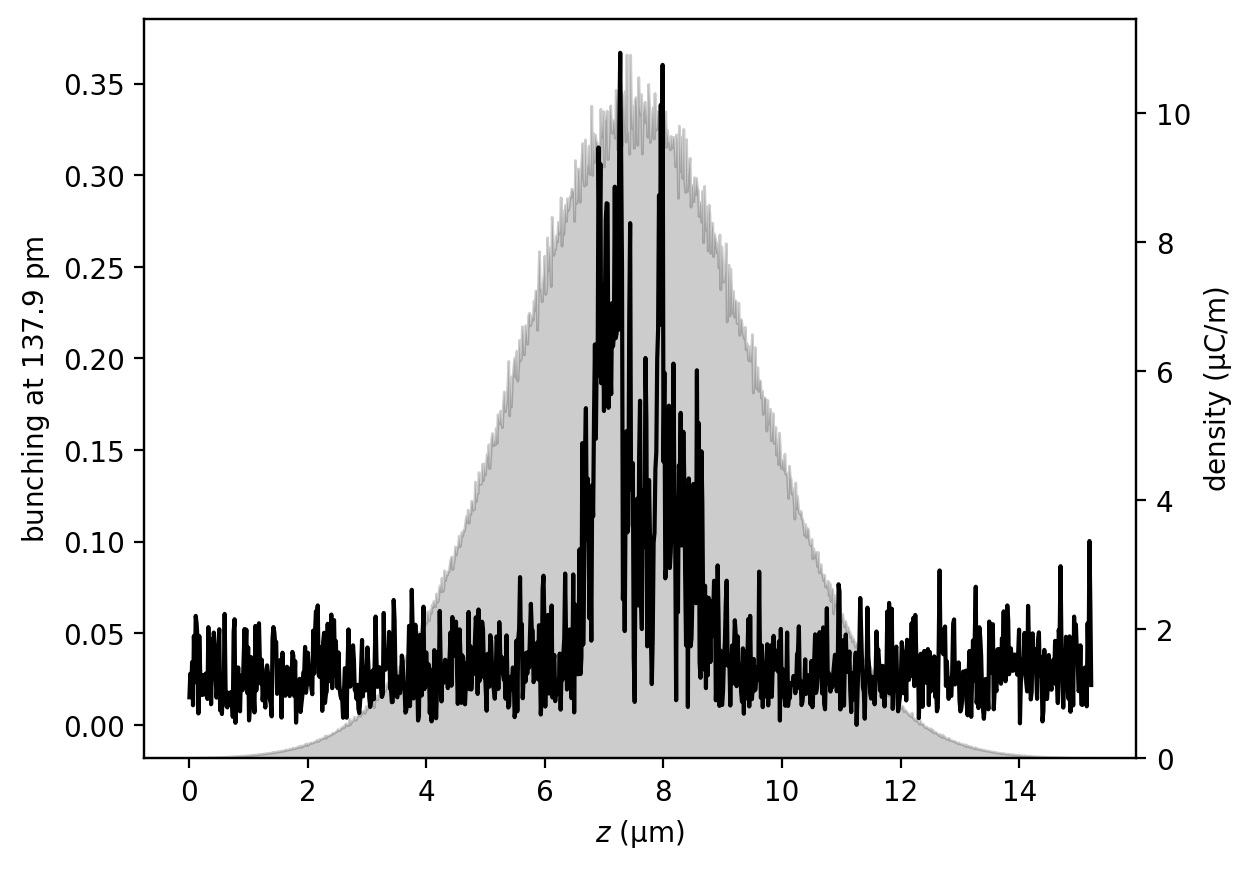

In [33]:
wavelength = G.input.main.setup.lambda0
bunching_key = f"bunching_{wavelength}"
P.drift_to_t()

P.slice_plot(bunching_key, n_slice=1000)

In [34]:
# Genesis4 data
final_bunching = G.output.beam["bunching"][-1, :]
current = G.output.beam["current"][-1, :]
s = G.output.global_["s"]


# ParticleGroup data
ss = P.slice_statistics(bunching_key, n_slice=len(s))
ss.keys()
x = ss["mean_z"]
y = ss[bunching_key]

Compare 

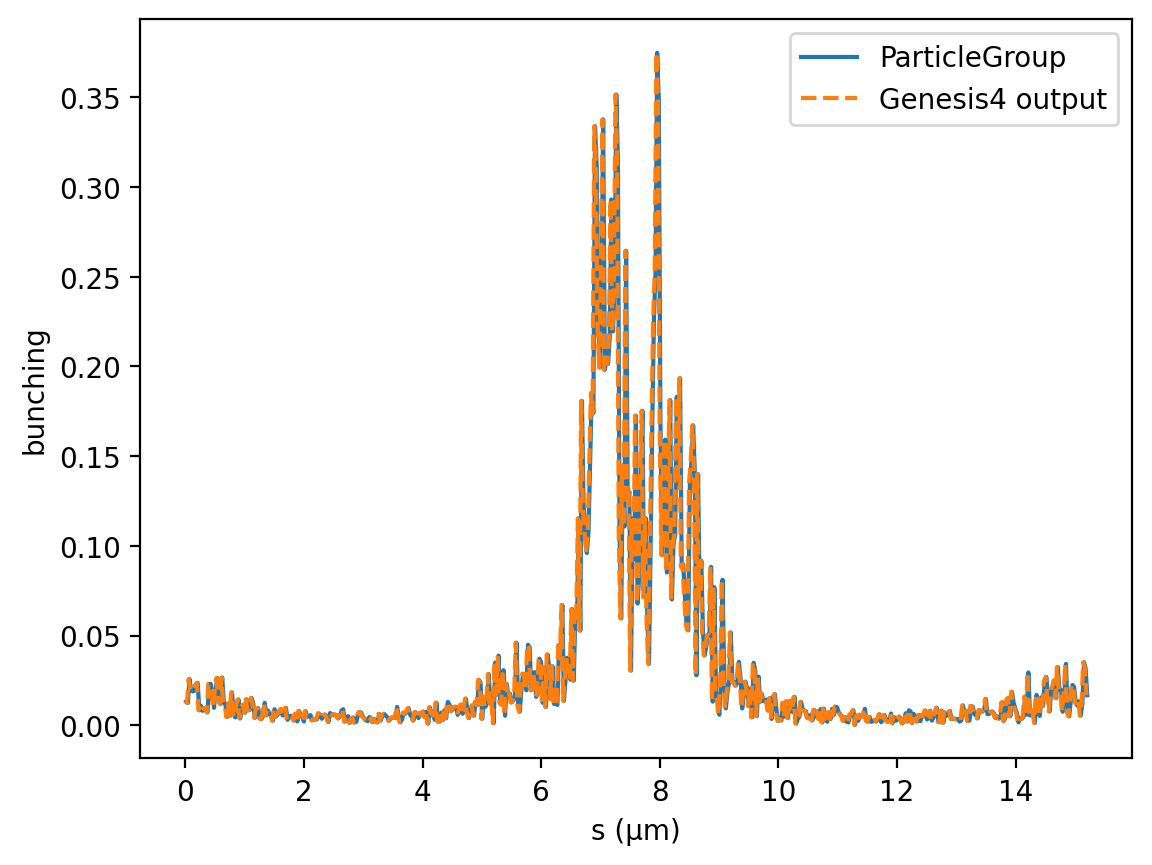

In [35]:
fig, ax = plt.subplots()
ax.plot(x * 1e6, y, label="ParticleGroup")
ax.plot(s * 1e6, final_bunching, "--", label="Genesis4 output")
ax.set_xlabel("s (µm)")
ax.set_ylabel("bunching")
plt.legend()

This is the average bunching from the ParticleGroup:

In [36]:
P.bunching(wavelength)

(-0.007790079397505053+0.0011914771391329359j)

That agrees with the appropriate averaging of Genesis4's bunching calc:

In [37]:
G.stat("bunching")[-1]

0.007880669691905443

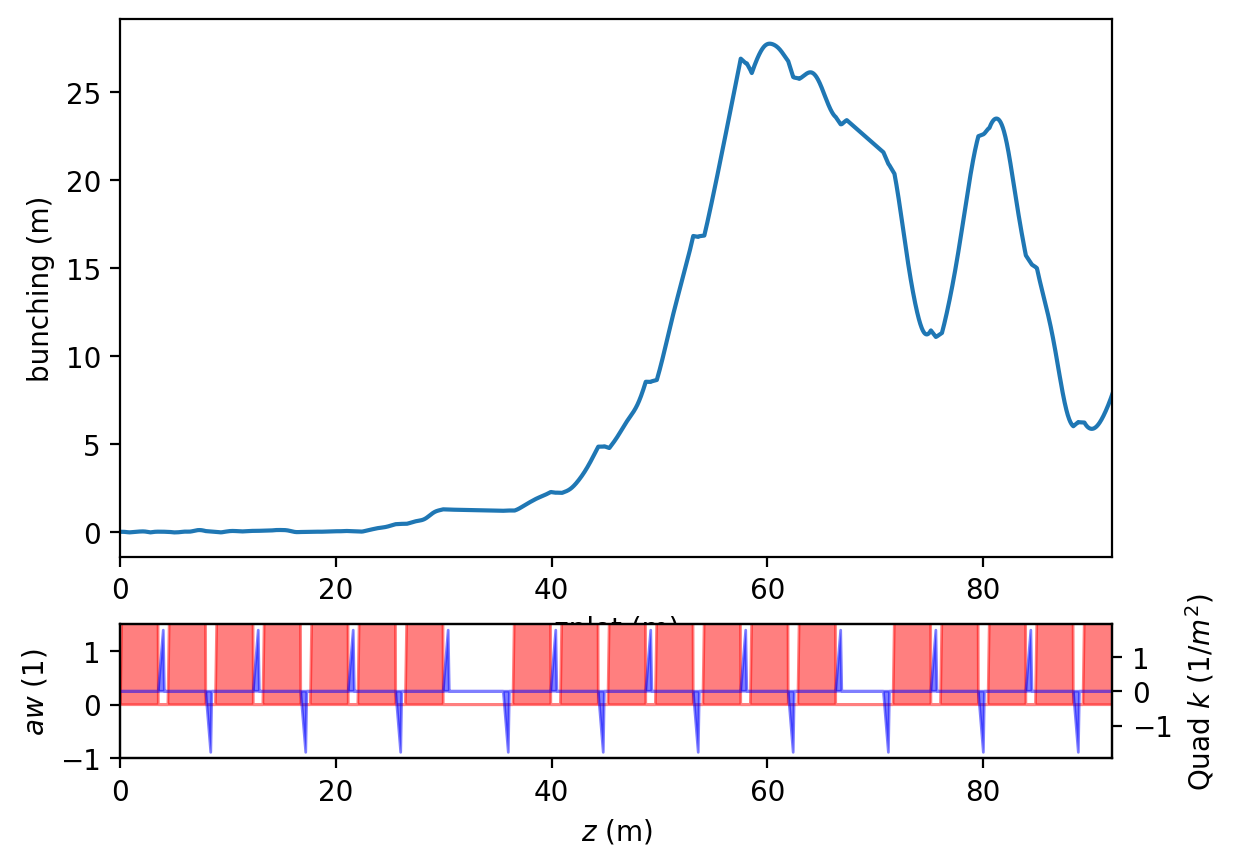

In [38]:
G.plot("bunching")

Check the total charge in pC:

In [39]:
P["charge"] / 1e-12  # pC

50.16037387875738

## Units

Each item in the output dict has a corresponding units

In [40]:
G.output.units("Beam/betax")

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

# Plotting

Convenient plotting of the data in `.output` is provided by `.plot`. The default is to plot the power. Depending on the key these statistics are averaged or integrated over the slices. Some keys like `power` are converted to `peak_power`, while `field_energy` is the integral over `field_power`. 

In [41]:
print(G.output.alias["power"])

Field/power


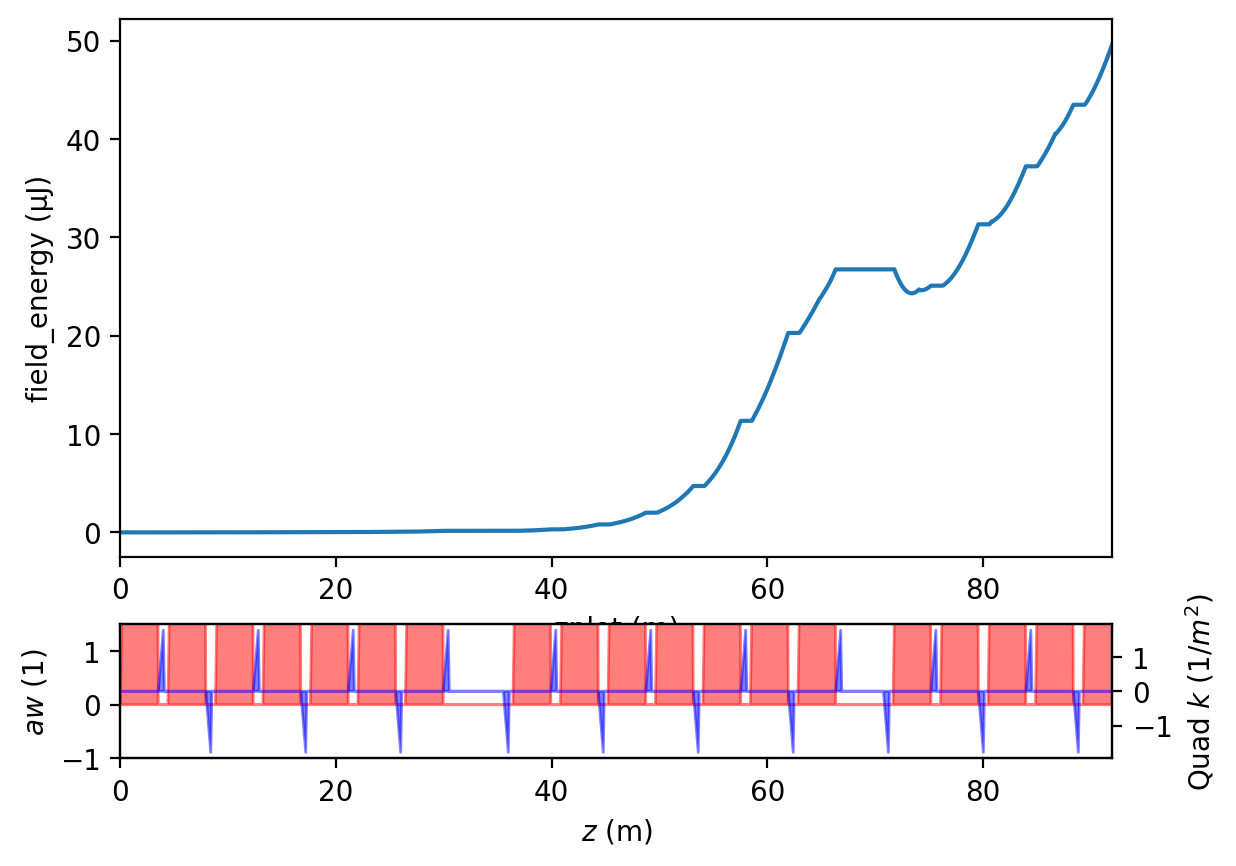

In [42]:
G.plot()

Left and right axes can be set this way:

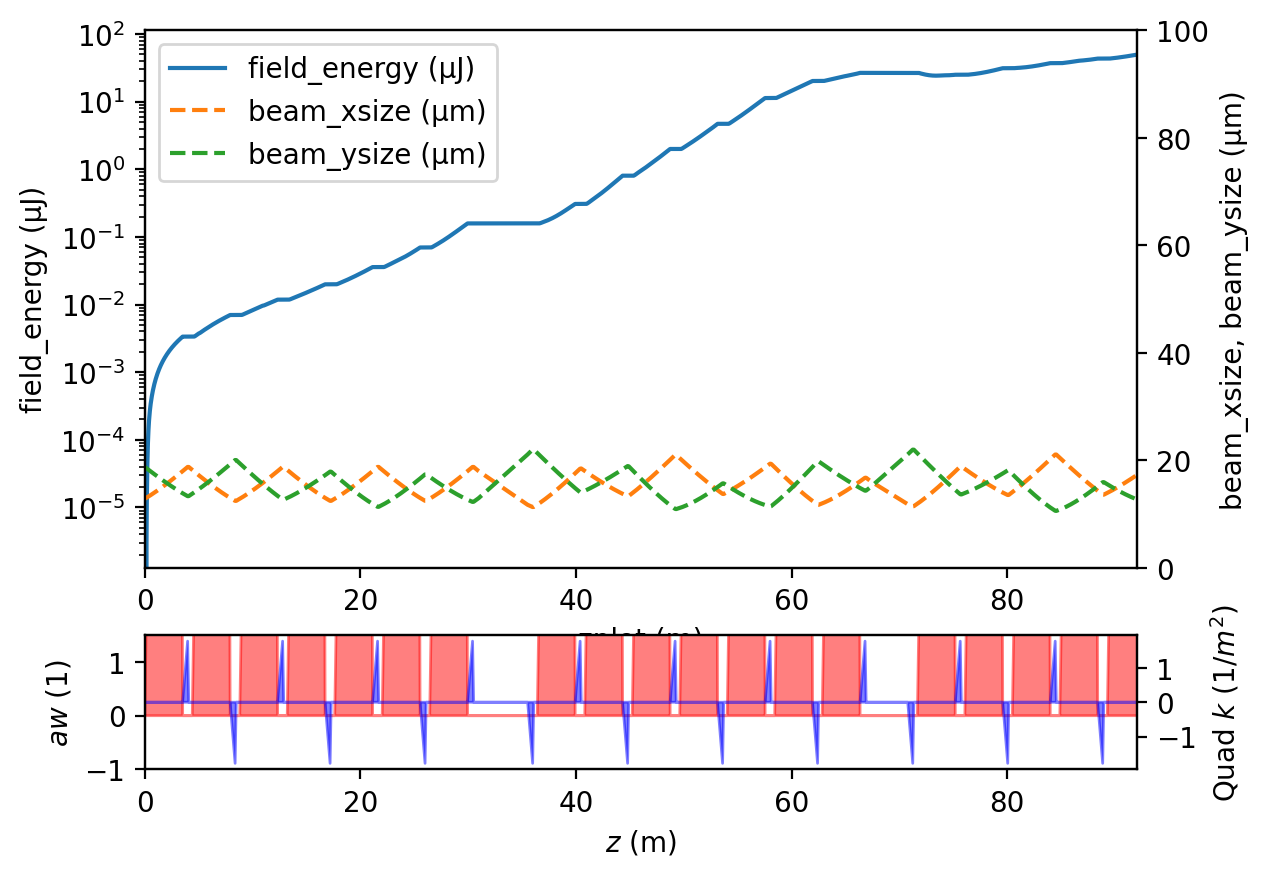

In [43]:
G.plot("field_energy", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 100e-6))

By default, these plots average over slices. In the case of beam sizes, simply averaging these does not take into account the effect of misaligned slices. To plot this, LUME-Genesis provides additional `beam_sigma_x`, `beam_sima_y`, `beam_sigma_energy` keys that properly project these quantities. The difference is noticable in the energy spread calculation:

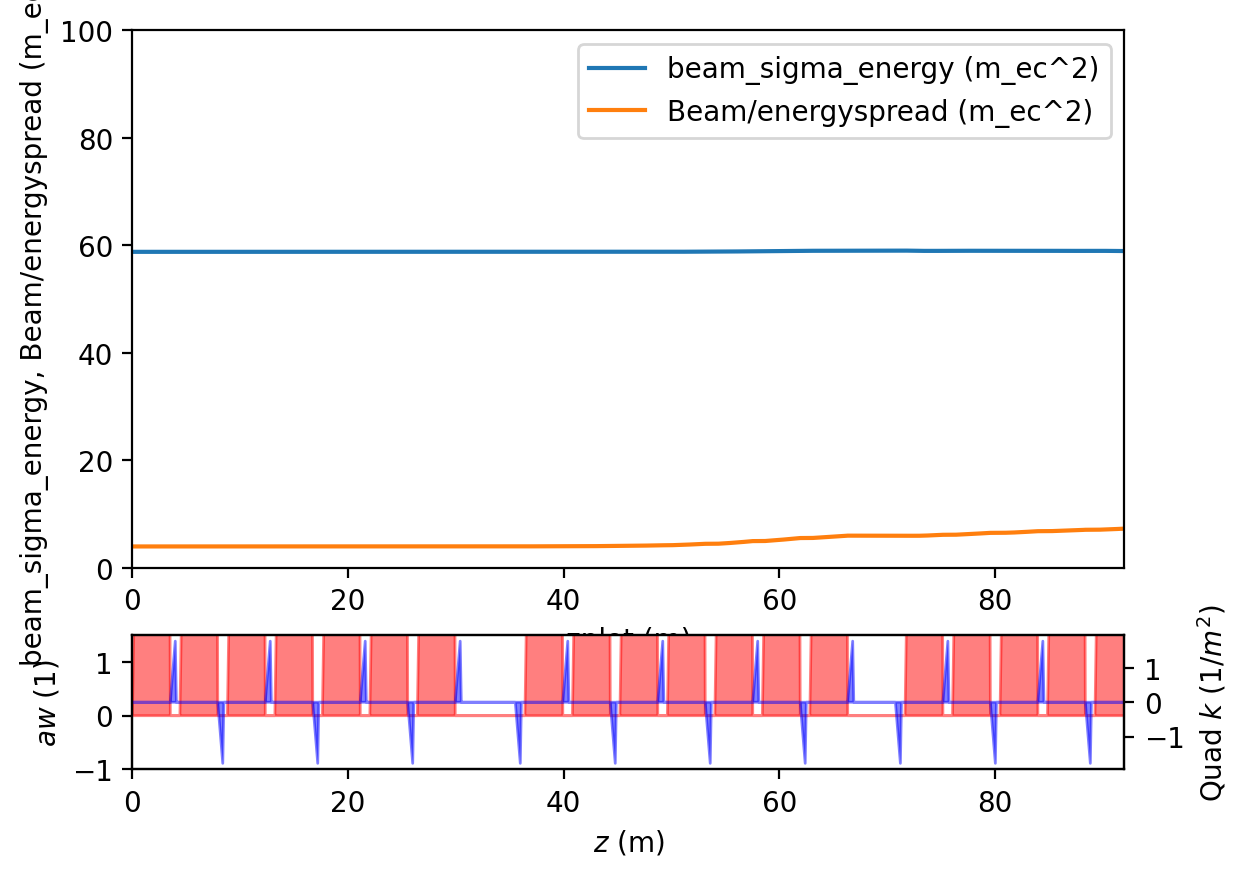

In [44]:
G.plot(["beam_sigma_energy", "Beam/energyspread"], ylim=(0, 100))

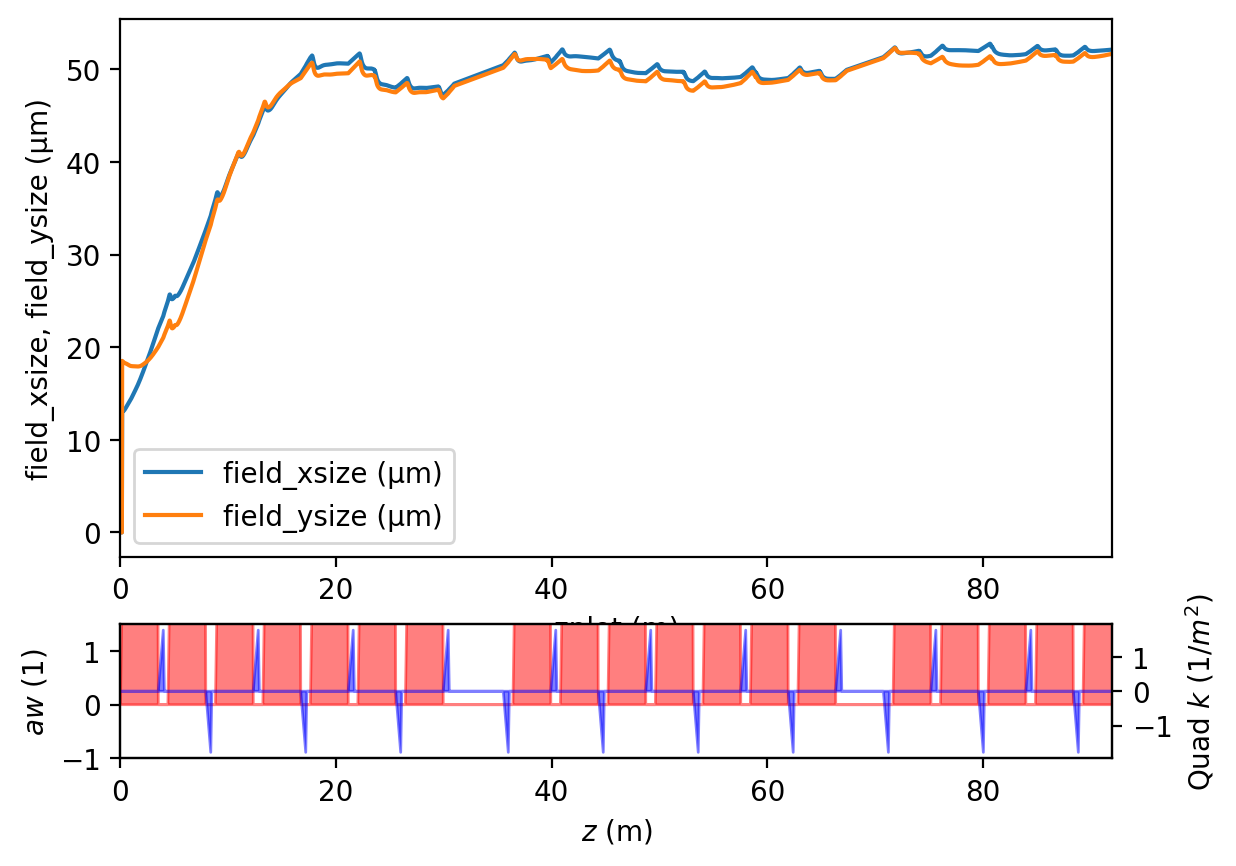

In [45]:
G.plot(["field_xsize", "field_ysize"])

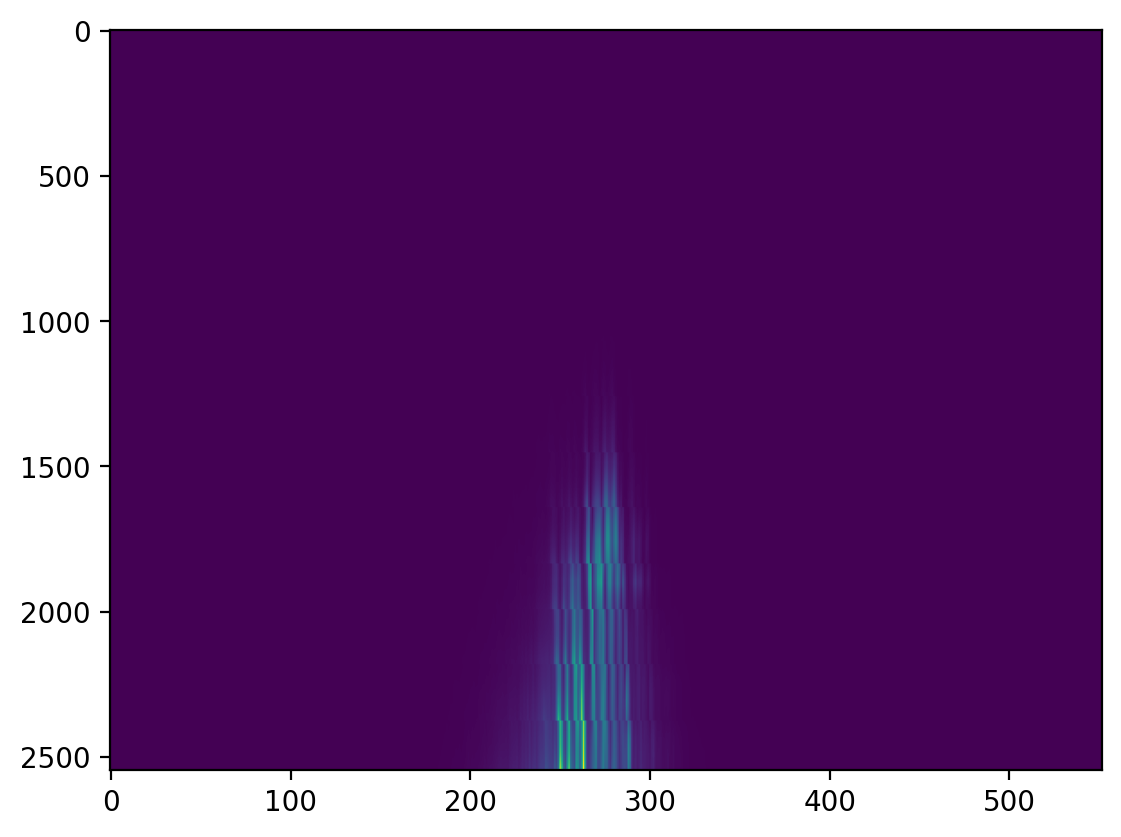

In [46]:
plt.imshow(G.output.field_info["power"], aspect="auto")

## Archiving

In [47]:
import genesis

G.archive("archived.h5")

Grestored = Genesis4.from_archive("archived.h5")
# assert len(output.data)

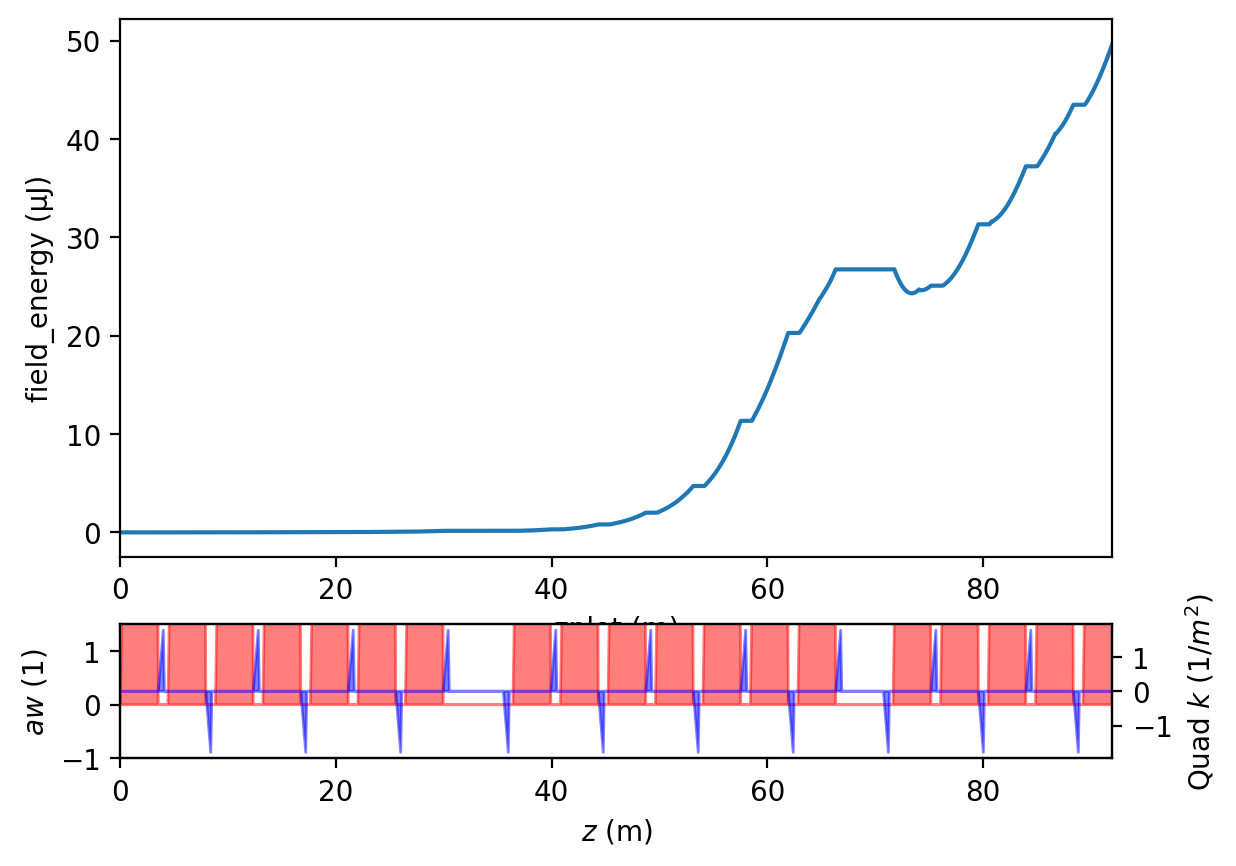

In [48]:
Grestored.output.plot()

# Manual loading of Genesis4 data

Sometimes it is necessary to run Genesis4 manually, and load the output into LUME-Genesis for further analysis.

First, let's create some input to run in a local directory `temp/`:

In [49]:
import os

os.makedirs("temp/", exist_ok=True)
G.write_input("temp/")

Now run on the command line:

In [50]:
!cd temp; ./run | tee log.txt

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:40:11 2024

MPI-Comm Size: 12 nodes

Parsing lattice file...
Setting up time window of 15.2233 microns with 552 sample points...
Generating input radiation field for HARM = 1 ...


Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...



Running Core Simulation...
Time-dependent run with 552 slices for a time window of 15.2233 microns
Initial analysis of electron beam and radiation field...


  Calculation: 0% done


  Calculation: 10% done


  Calculation: 20% done


  Calculation: 30% done


  Calculation: 40% done


  Calculation: 50% done


  Calculation: 60% done


  Calculation: 70% done


  Calculation: 80% done


  Calculation: 90% done


Calculation terminated due to requested stop.
Writing output file...



Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing field distribution to file: end.fld.h5 ...


Writing particle distribution to file: end.par.h5 ...



Program is terminating...
Ending Time: Tue May 14 16:43:33 2024
Total Wall Clock Time: 117.7 seconds
-------------------------------------


Using the `use_temp_dir=False` and `workdir` options, the input and output data can be loaded into a new Genesis4 object:

In [51]:
G2 = Genesis4("genesis4.in", use_temp_dir=False, workdir="temp/", verbose=True)
G2.configure()
output = G2.load_output()

Configured to run in: temp/


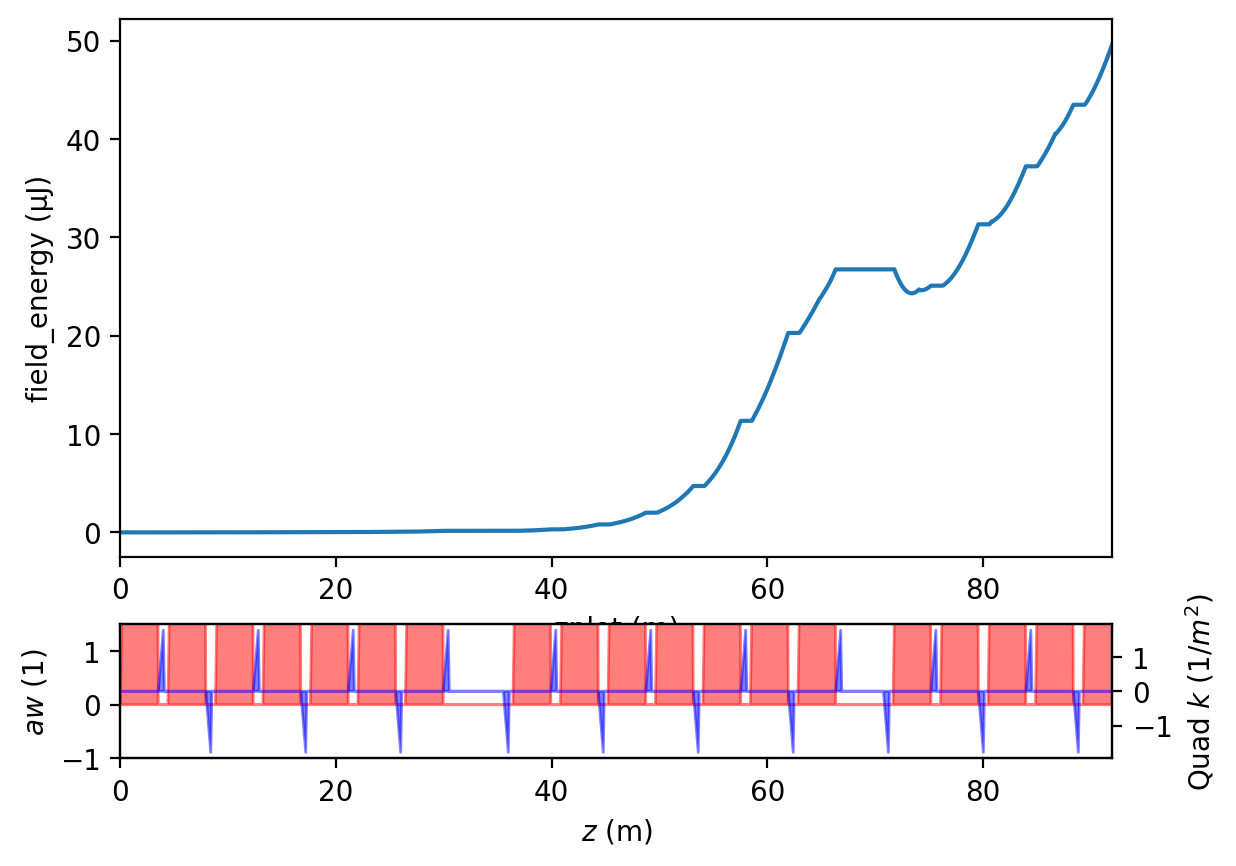

In [52]:
output.plot()

# Cleanup

In [53]:
import shutil

shutil.rmtree("temp")
os.remove("archived.h5")